In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import ast
from collections import Counter
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, brier_score_loss, confusion_matrix
from sklearn.calibration import calibration_curve
import calibration as cal
from netcal.metrics import ECE, MCE


## CLASSIFICATION TASK

In [33]:
llama = pd.read_csv('./output/llama_classification.csv') 
gemma = pd.read_csv('./output/gemma_classification.csv')
ml_svc = pd.read_csv('output/SVC_gte-Qwen2-1.5B-instruct.csv')
ml_rf = pd.read_csv('output/RandomForestClassifier_gte-Qwen2-1.5B-instruct.csv')
ml_cv = pd.read_csv('./output/SVC_CountVectorizer.csv')

In [ ]:
def compute_average_probabilities(row, column_probs):
    predictions = row['prediction']
    predictions = ast.literal_eval(predictions) 
    probabilities = row[column_probs]
    probabilities = ast.literal_eval(probabilities) #convert string to float

    most_frequent = Counter(predictions).most_common(1)[0][0]     # Retrieve the most common class
    indices = [i for i, x in enumerate(predictions) if x == most_frequent]

    # List the probabilities of the common class
    filtered_probabilities = [probabilities[i] for i in indices]
    # Compute the average of the most common class
    if filtered_probabilities:
        avg_probabilities = np.mean(filtered_probabilities, axis=0)
    else:
        avg_probabilities = [None] * len(probabilities[0])  # Handle case with no valid probabilities
    
    return most_frequent, avg_probabilities

column_probabilities = 'norm_probabilities' #raw_probabilities
gemma[['Predicted_State','average_probabilities']] = gemma.apply(compute_average_probabilities, axis=1, args=(column_probabilities), result_type='expand')
llama[['Predicted_State','average_probabilities']] = llama.apply(compute_average_probabilities, axis=1, args=(column_probabilities), result_type='expand')


In [35]:
# Extract probabilities for class ON
llama['probabilities'] = llama['average_probabilities'].apply(lambda x: x[0])
gemma['probabilities'] = gemma['average_probabilities'].apply(lambda x: x[0])

In [ ]:
def compute_roc_auc(y, positive_probabilities, label="ON"):
    roc_auc = roc_auc_score(y, positive_probabilities)
    fpr, tpr, _ = roc_curve(y, positive_probabilities, pos_label=label)
    return roc_auc, fpr, tpr

score_llama, fpr_llama, tpr_llama  = compute_roc_auc(llama.State, llama.probabilities)

score_gemma, fpr_gemma, tpr_gemma = compute_roc_auc(gemma.State, gemma.probabilities)

score_ml, fpr_ml, tpr_ml = compute_roc_auc(ml_svc.State, ml_svc.probabilities)

score_rf, fpr_rf, tpr_rf = compute_roc_auc(ml_rf.State, ml_rf.probabilities)

score_cv, fpr_cv, tpr_cv = compute_roc_auc(ml_cv.State, ml_cv.probabilities)

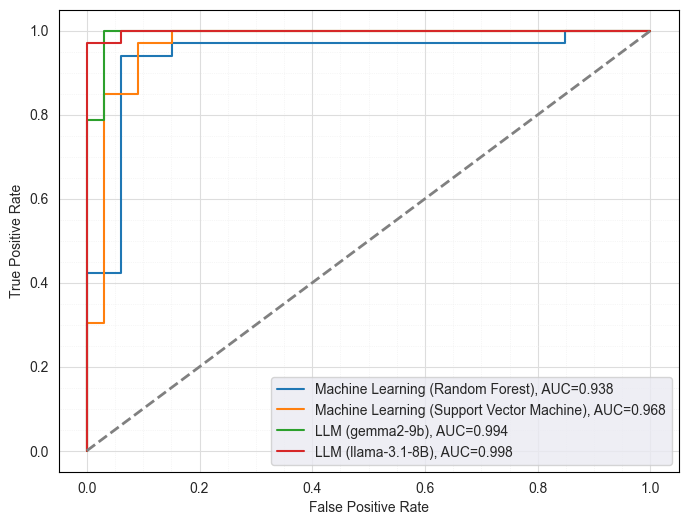

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(fpr_rf,tpr_rf,label=f"Machine Learning (Random Forest), AUC={score_rf:.3f}")
plt.plot(fpr_ml,tpr_ml,label=f"Machine Learning (Support Vector Machine), AUC={score_ml:.3f}")
plt.plot(fpr_gemma,tpr_gemma,label=f"LLM (gemma2-9b), AUC={score_gemma:.3f}")
plt.plot(fpr_llama, tpr_llama,label=f"LLM (llama-3.1-8B), AUC={score_llama:.3f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.legend(loc=0)
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.set_facecolor('white')
ax.minorticks_on()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color('black')

#plt.savefig(f"./output/figures/roc_curves_plus_cv.svg", format='svg', dpi=1200)

### Calibration

In [38]:
def compute_calibration_metrics(y_true, y_prob, n_bins=10, pos_label="ON", model_name=None):
    brier_score = brier_score_loss(y_true, y_prob, pos_label=pos_label)
    ece_cal = cal.get_calibration_error(y_prob,y_true)
    ece_guo = cal.get_ece(y_prob,y_true)
    ece = ECE(n_bins)
    mce = MCE(n_bins)
    ece_netcal = ece.measure(np.array(y_prob),np.array(y_true))
    mce = mce.measure(np.array(y_prob),np.array(y_true))
    print(f"{model_name} -> Brier score: {brier_score:.3f}, ECE cal {ece_cal:.3f}, ECE guo {ece_guo:.3f},\nECE netcal {ece_netcal:.3f}, MCE netcal {mce:.3f}\n")
    

In [39]:
y_num = np.array(ml_svc.State.map({"ON": 1, "OFF": 0}))
compute_calibration_metrics(y_num, llama['probabilities'],model_name='llama')

compute_calibration_metrics(y_num, gemma['probabilities'],model_name='gemma')

compute_calibration_metrics(y_num, ml_rf.probabilities, model_name='rf')

compute_calibration_metrics(y_num, ml_svc.probabilities, model_name='svc') # SVC



llama -> Brier score: 0.425, ECE cal 0.081, ECE guo 0.078,
ECE netcal 0.078, MCE netcal 0.420

gemma -> Brier score: 0.385, ECE cal 0.104, ECE guo 0.137,
ECE netcal 0.128, MCE netcal 0.430

rf -> Brier score: 0.273, ECE cal 0.301, ECE guo 0.280,
ECE netcal 0.294, MCE netcal 0.446

svc -> Brier score: 0.385, ECE cal 0.076, ECE guo 0.093,
ECE netcal 0.078, MCE netcal 0.373



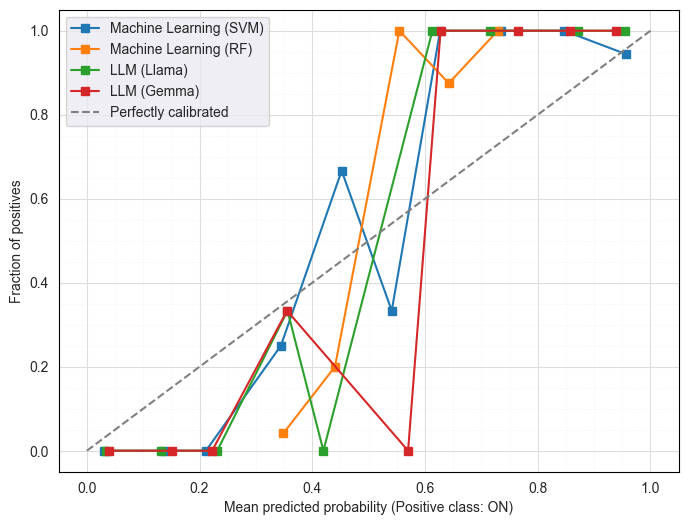

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
prob_true, prob_pred = calibration_curve(ml_svc.State, ml_svc.probabilities, n_bins=10, pos_label="ON")
plt.plot(prob_pred,prob_true, "s-", label='Machine Learning (SVM)')
prob_true, prob_pred = calibration_curve(ml_rf.State, ml_rf.probabilities, n_bins=10, pos_label="ON")
plt.plot(prob_pred,prob_true, "s-", label='Machine Learning (RF)')
prob_true, prob_pred = calibration_curve(llama.State, llama['probabilities'], n_bins=10, pos_label="ON")
plt.plot(prob_pred,prob_true, "s-", label='LLM (Llama)')
rob_true, prob_pred = calibration_curve(gemma.State, gemma['probabilities'], n_bins=10, pos_label="ON")
plt.plot(prob_pred,prob_true, "s-", label='LLM (Gemma)')
plt.plot([0,1],[0,1], linestyle='--', label='Perfectly calibrated', color='grey')
plt.xlabel('Mean predicted probability (Positive class: ON)')
plt.ylabel('Fraction of positives')
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# Show the minor grid as well. Style it in very light gray as a thin,
# dotted line.
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.set_facecolor('white')
ax.minorticks_on()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_color('black')
plt.legend()
#plt.savefig(f"./output/figures/calibration_curves.svg", format='svg', dpi=1200)
#plt.show()

#### REPLICATED RECORDINGS

In [41]:
gemma_replicated = pd.read_csv('./output/gemma_on_off_replicated_10.csv')
svc = pd.read_csv('./output/replicated_SVC_gte-Qwen2-1.5B-instruct.csv')

In [ ]:
gemma_replicated[['Predicted_State','average_probabilities']] = gemma_replicated.apply(compute_average_probabilities, axis=1,args=(column_probabilities), result_type='expand')
gemma_replicated['positive_probabilities'] = gemma_replicated['average_probabilities'].apply(lambda x: x[0])

In [43]:
print(classification_report(gemma_replicated['State'], gemma_replicated['Predicted_State'], digits=3))

              precision    recall  f1-score   support

         OFF      1.000     1.000     1.000         7

    accuracy                          1.000         7
   macro avg      1.000     1.000     1.000         7
weighted avg      1.000     1.000     1.000         7



## REGRESSION TASK: NFS SCORE PREDICTIONS

In [44]:
def print_correlation_plot(df, title=None, save_fig=False, name_figure='nfs.svg'):
    y = df['NFS_score']
    predictions = df['prediction']

    rmse = np.sqrt(mean_squared_error(y,  predictions))
    r2 = r2_score(y,  predictions)
    correlation = spearmanr(y,  predictions)
    print("mae:", mean_absolute_error(y,  predictions))
    print("correlation: ", correlation)
    print(f"RMSE: {rmse}, r2: {r2}")

    fig, ax = plt.subplots(figsize=(8, 6))
    colors = ['#055503' if s == 'ON' else '#730A95' for s in df['State']]

    # Add error bars
    #plt.errorbar(y, predictions), yerr=y_err, fmt='none', ecolor='grey', capsize=2)
    plt.scatter(y,  predictions,color=colors, alpha=0.7)

    plt.plot([min(y), max(y)], [min(y), max(y)], '--',color='grey')  # Line for perfect correlation

    # Add RMSE and R² to the plot
    plt.text(0.05, 0.95, f'RMSE = {rmse:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.05, 0.90, f'R² = {r2:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    p_value = "<0.001" if (correlation.pvalue < 0.001) else f"{correlation.pvalue:.2e}"

    plt.text(0.05, 0.85, f'Spearman Corr = {correlation.statistic:.2f}, \np-value {p_value}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    # Set plot labels and title
    plt.xlabel('Actual neuropsychiatric state score', fontsize=12)
    plt.ylabel('Predicted neuropsychiatric state score', fontsize=12)

    plt.title(f'{title}', fontsize=14)
    ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
    ax.set_facecolor('white')
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_color('black')
    ax.minorticks_on()
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    legend_elements = [Line2D([0], [0], marker='o', color='none', label='ON medication', markerfacecolor='#055503', markersize=8,alpha=0.7),
                       Line2D([0], [0], marker='o', color='none', label='OFF medication', markerfacecolor='#730A95', markersize=8,alpha=0.7)]
    ax.legend(handles=legend_elements, loc='lower right')

    if save_fig:
        plt.savefig(f"./output/figures/{name_figure}.svg", format='svg', dpi=1200)
    plt.show()


In [45]:
## SEMANTIC SEARCH APPROACH
df_ss = pd.read_csv('./output/ss_pred_n_5_corpus_patients_task_regression_multi-qa-mpnet-base-dot-v1.csv')

mae: 11.651515151515152
correlation:  SignificanceResult(statistic=0.6366429522993293, pvalue=9.146925763578247e-09)
RMSE: 14.026490089912881, r2: 0.43137876765226535


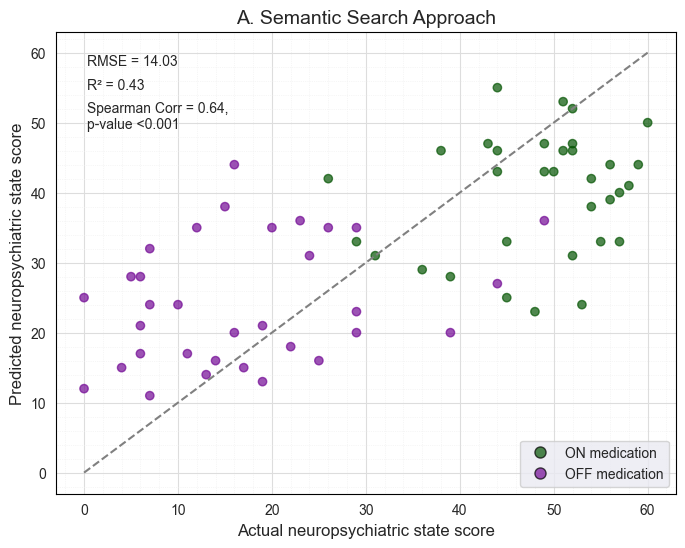

In [46]:
print_correlation_plot(df_ss,title="A. Semantic Search Approach", name_figure='ss_nfs',save_fig=True)

In [47]:
### MACHINLE LEARNING
df_ml = pd.read_csv('./output/regression_RandomForestRegressor_gte-Qwen2-1.5B-instruct.csv')

mae: 8.688918283181819
correlation:  SignificanceResult(statistic=0.7574094142923552, pvalue=1.840601094922752e-13)
RMSE: 11.220984788286495, r2: 0.6360958561198216


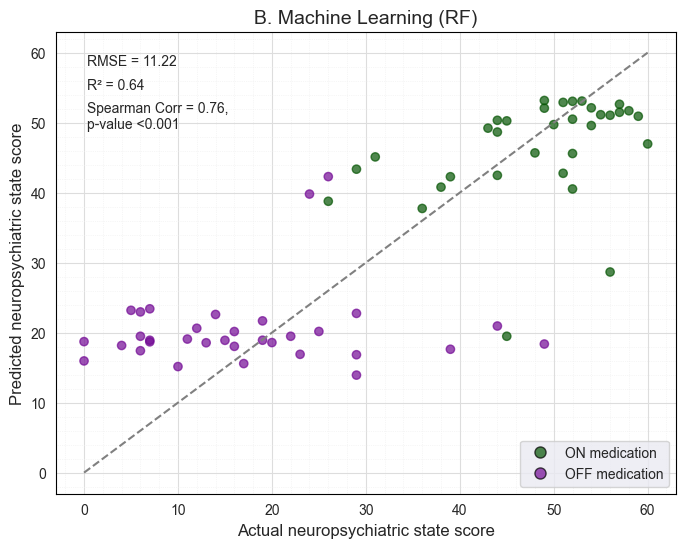

In [48]:
print_correlation_plot(df_ml,title="B. Machine Learning (RF)",save_fig=True, name_figure='rf_nfs')

In [49]:
### LLM APPROACH
df_llm = pd.read_csv('./output/gemma_semantic_selection_multiple_prompt.csv')


In [ ]:
def calculate_averages(row):
    row = ast.literal_eval(row)
    first_elements = list(map(float, row))
    avg_first = sum(first_elements) / len(first_elements)
    return {'avg': avg_first, 'min':np.percentile(first_elements,2.5), 'max':np.percentile(first_elements,97.5)}

df_llm['avg_nfs'] = df_llm['prediction'].apply(calculate_averages)
df_llm.head()

In [51]:
df_llm['prediction'] = df_llm['avg_nfs'].apply(lambda x: x['avg'])

mae: 8.071212121212122
correlation:  SignificanceResult(statistic=0.8056844320955006, pvalue=3.406293224387523e-16)
RMSE: 10.587735901275188, r2: 0.676010262929513


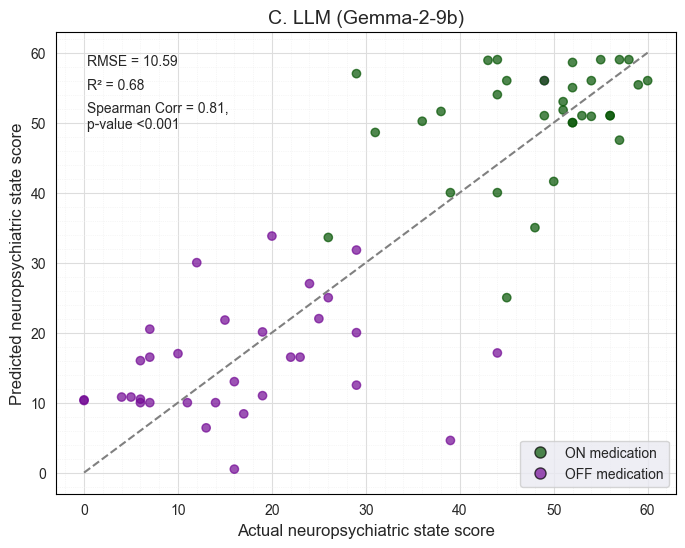

In [52]:
print_correlation_plot(df_llm,title="C. LLM (Gemma-2-9b)", save_fig=True, name_figure='gemma_nfs')